In [2]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from skimage import (
    color, draw, feature, filters, exposure, segmentation, util, transform)
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

## Reduce beam hardening artifact

### Load example image

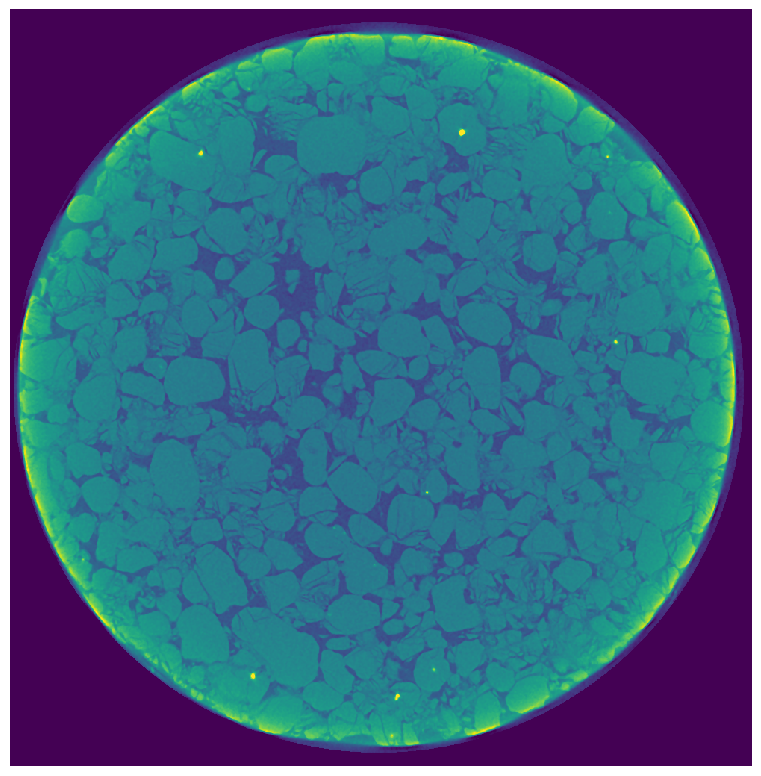

In [2]:
def save_F83_01_bh750():
    imgs_path = Path('../data/F83_01_raw')
    imgs = segment.load_images(
        imgs_path,
        slice_crop=None,
        file_suffix='.tiff'
    )
    imgs_res = segment.preprocess(
        imgs, median_filter=True, rescale_intensity_range=[25.5, 99.98]
    )
    bh_example_img = imgs_res[750, ...]
    return bh_example_img
bh750_path = Path('../data/F83_01_bh750.tif')
img = iio.imread(bh750_path)
img = util.img_as_float(img)
fig, ax = view.images(
    img,
    fig_w=7.5,
    dpi=100
)

- copy image
- min threshold mask
- replace masked region with mean value
- large gaussian filter on copy
- min threshold mask blurred image
- subtract from full iamge

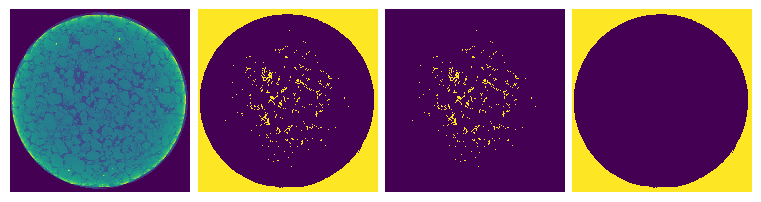

In [3]:
thresh_val = filters.threshold_otsu(img)
img_otsu = img < thresh_val
img_otsu_no_border = segmentation.clear_border(img_otsu)
img_border = img_otsu.astype(np.ubyte) - img_otsu_no_border
fig, axes = view.images([img, img_otsu, img_otsu_no_border, img_border])
plt.show()

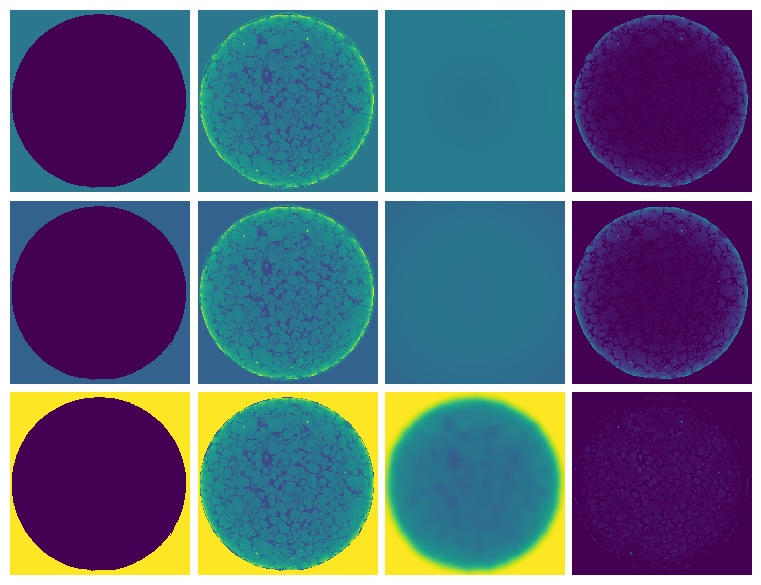

In [4]:
img_med = np.full_like(img, np.median(img)) * img_border
img_avg = np.full_like(img, np.mean(img)) * img_border
img_max = np.full_like(img, np.max(img)) * img_border
img_bg_med = img + img_med
img_bg_avg = img + img_avg
img_bg_max = img + img_max
img_med_smooth = filters.gaussian(img_bg_med, sigma=img.shape[0]//5)
img_avg_smooth = filters.gaussian(img_bg_avg, sigma=img.shape[0]//5)
img_max_smooth = filters.gaussian(img_bg_max, sigma=img.shape[0]//50)
img_sub_med = img - img_med_smooth
img_sub_avg = img - img_avg_smooth
img_sub_max = img - img_max_smooth
fig, axes = view.images(
    [
        img_med, img_bg_med, img_med_smooth, img_sub_med,
        img_avg, img_bg_avg, img_avg_smooth, img_sub_avg,
        img_max, img_bg_max, img_max_smooth, img_sub_max,
    ], imgs_per_row=4, vmin=0, vmax=1)
plt.show()

In [5]:
edges = feature.canny(
    img, sigma=2.0, low_threshold=0.25, high_threshold=1)
edge_values = edges * img
rows, cols = np.nonzero(edge_values)
edge_med = np.median(edge_values[rows, cols])
print(edge_med)

0.415533684290837


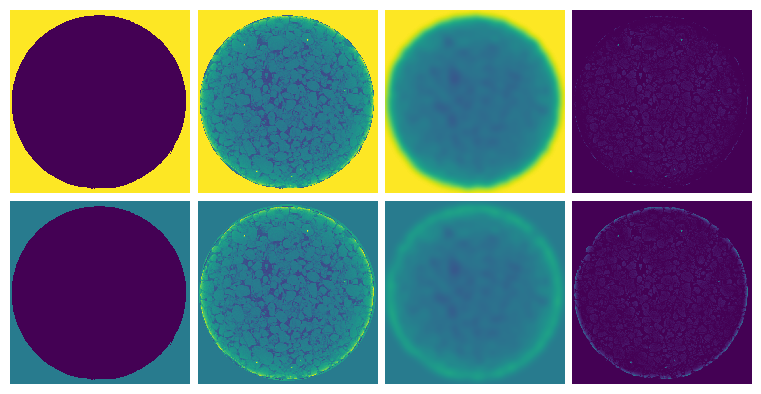

In [6]:
img_edge = np.full_like(img, edge_med) * img_border
img_bg_edge = img + img_edge
img_edge_smooth = filters.gaussian(img_bg_edge, sigma=img.shape[0]//50)
img_sub_edge = img - img_edge_smooth
fig, axes = view.images(
    [
        img_max, img_bg_max, img_max_smooth, img_sub_max,
        img_edge, img_bg_edge, img_edge_smooth, img_sub_edge,
    ], imgs_per_row=4, vmin=0, vmax=1)
plt.show()

<class 'tuple'>


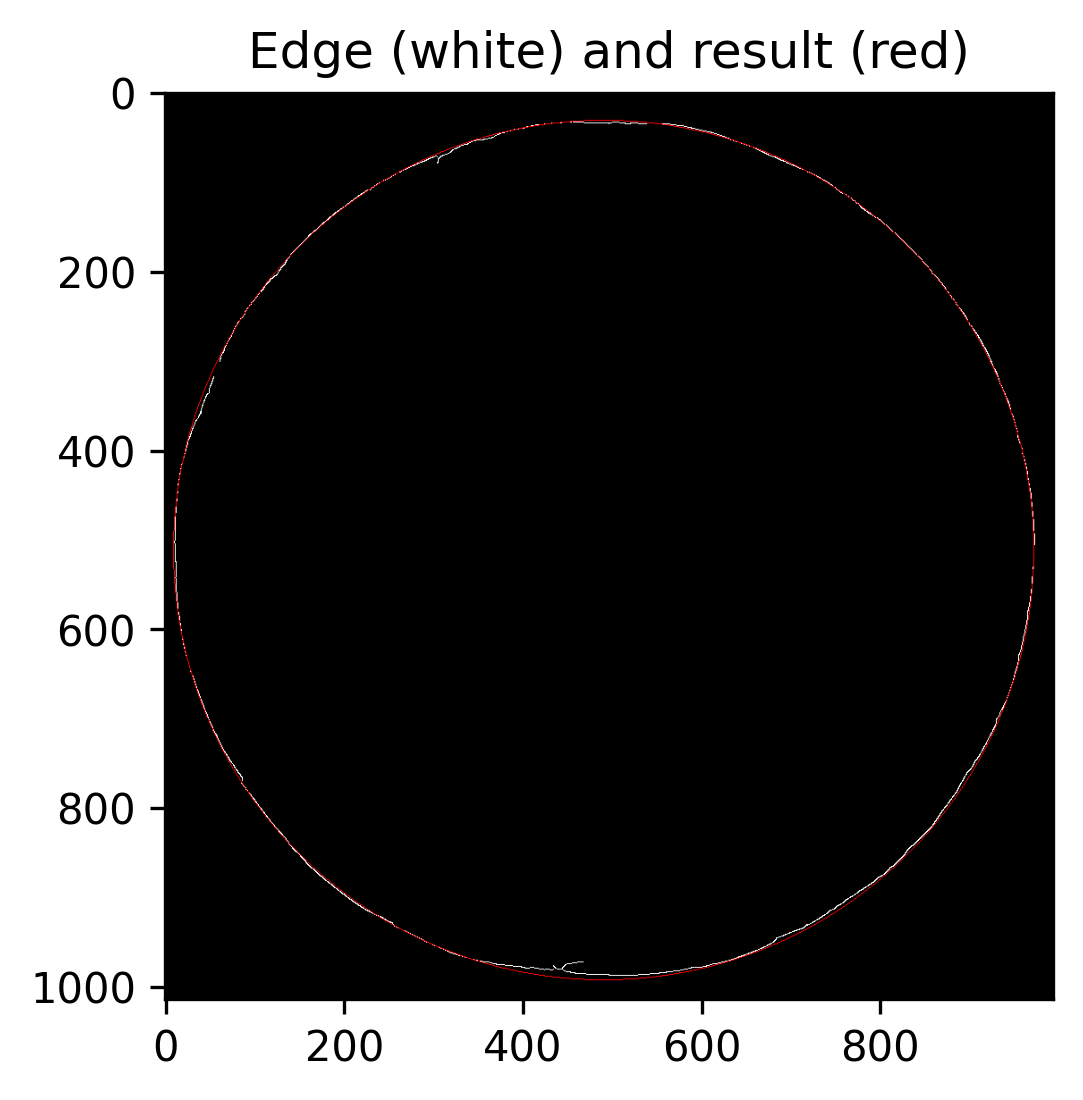

In [7]:
edges = feature.canny(
    img, sigma=2.0, low_threshold=0.25, high_threshold=1)
# Perform a Hough Transform
hough_radii = np.arange(img.shape[0] // 4, img.shape[0]//2, 2)
hspaces = transform.hough_circle(edges, hough_radii)
results = transform.hough_circle_peaks(hspaces, hough_radii, num_peaks=1)
print(type(results))
accum, cx, cy, r = [row[0] for row in results]
# Draw circle
rows, cols = draw.circle_perimeter(cy, cx, r, shape=img.shape)
edges_rgb = color.gray2rgb(util.img_as_ubyte(edges))
edges_rgb[rows, cols] = (255, 0, 0)

fig, ax = plt.subplots(dpi=300)
ax.set_title('Edge (white) and result (red)')
ax.imshow(edges_rgb)
plt.show()
# img_flood = segmentation.flood(img.copy(), (0, 0))

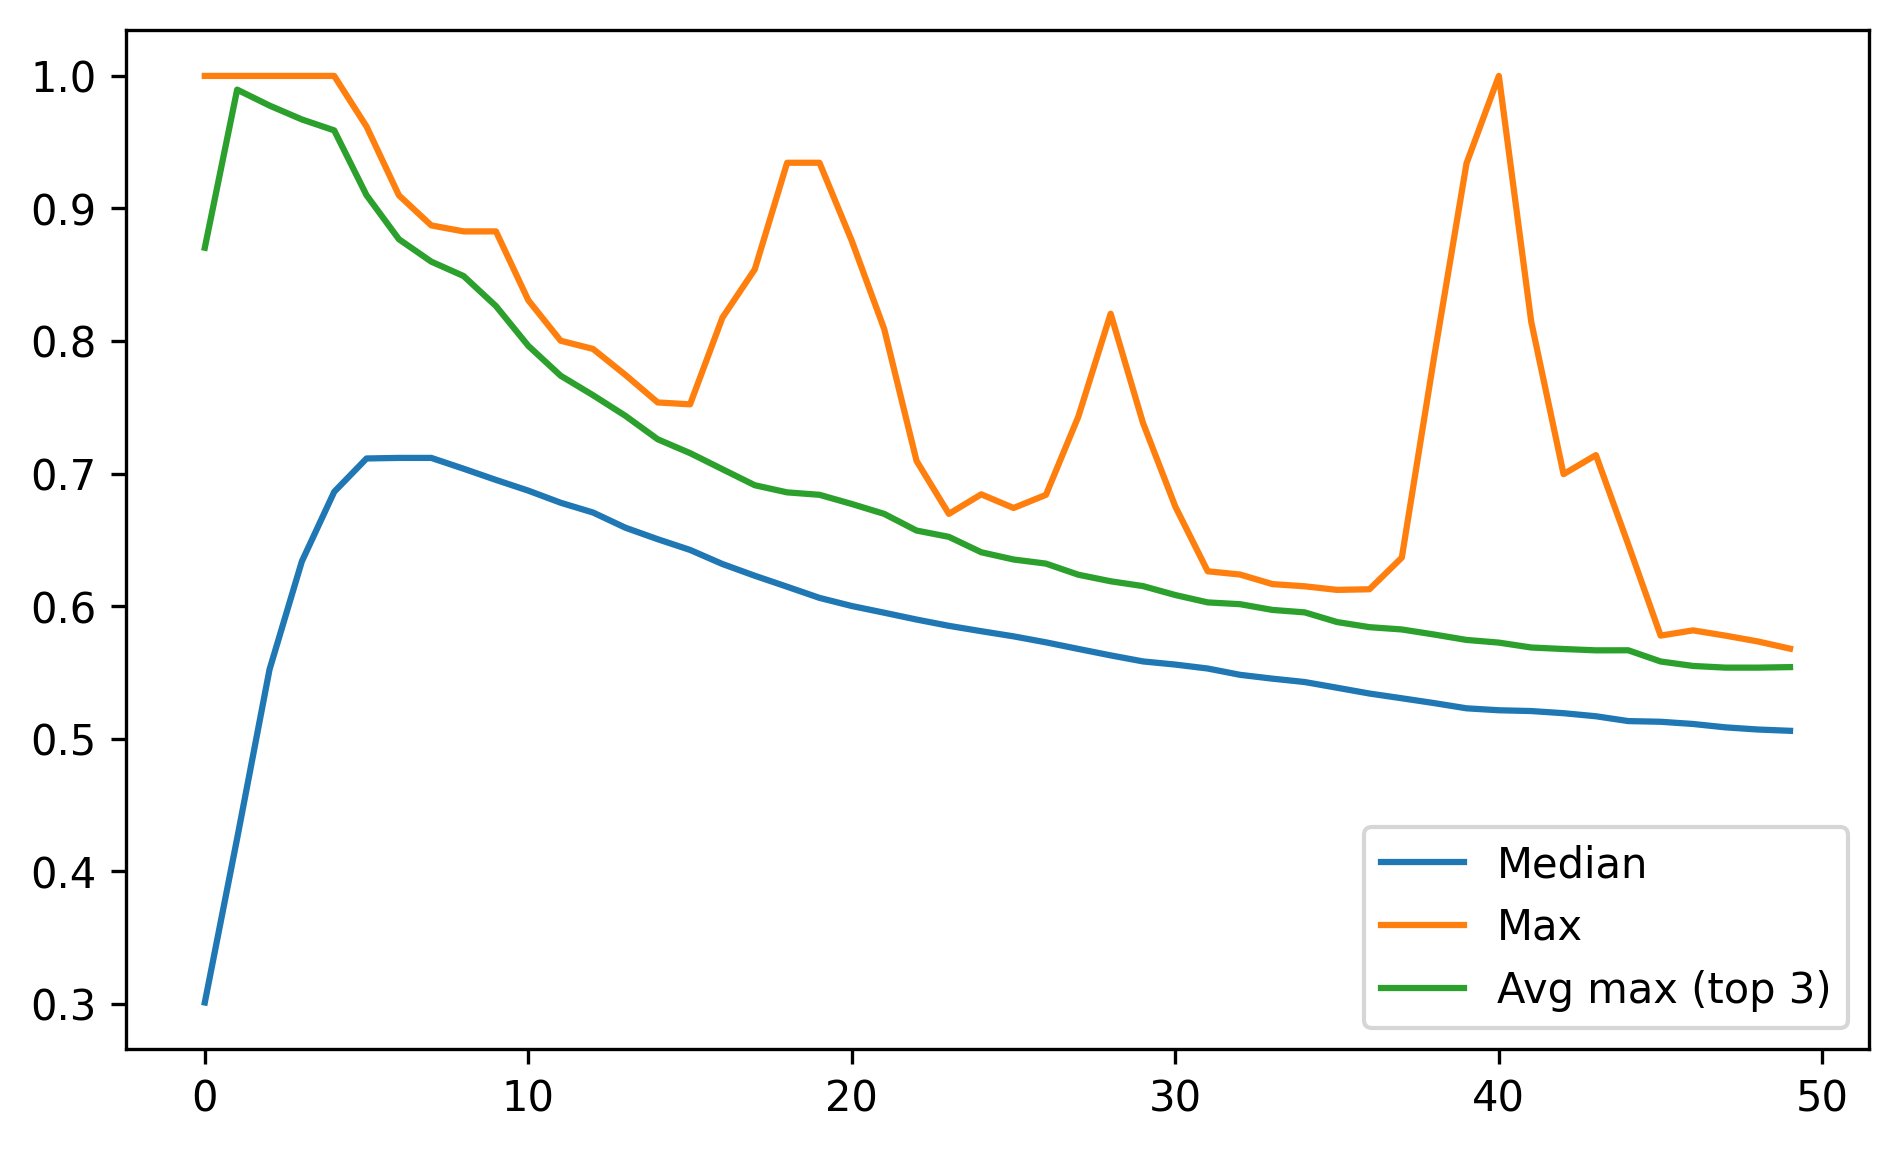

In [8]:
med_vals = []
max_vals = []
max_avg_vals = []
for r_sub in np.arange(0, 50):
    # Draw circle
    rows, cols = draw.circle_perimeter(cy, cx, r - r_sub, shape=img.shape)
    circ_med = np.median(img[rows, cols])
    med_vals.append(circ_med)
    circ_max = np.max(img[rows, cols])
    max_vals.append(circ_max)
    circ_max_avg = np.median(
        [img[rows, cols][i] for i in np.argsort(-img[rows, cols])[:50]])
    max_avg_vals.append(circ_max_avg)
# med_vals = np.array(med_vals)
# max_vals = np.array(max_vals)
# max_i = np.argmax(med_vals)
# print(max_i)
# max_val = med_vals[max_i]
# print(max_val)
fig, ax = plt.subplots(figsize=(7.5, 4.5), dpi=300)
ax.plot(med_vals, label='Median')
ax.plot(max_vals, label='Max')
ax.plot(max_avg_vals, label='Avg max (top 3)')
# ax.axvline(max_i, c='r')
ax.legend()
plt.show()

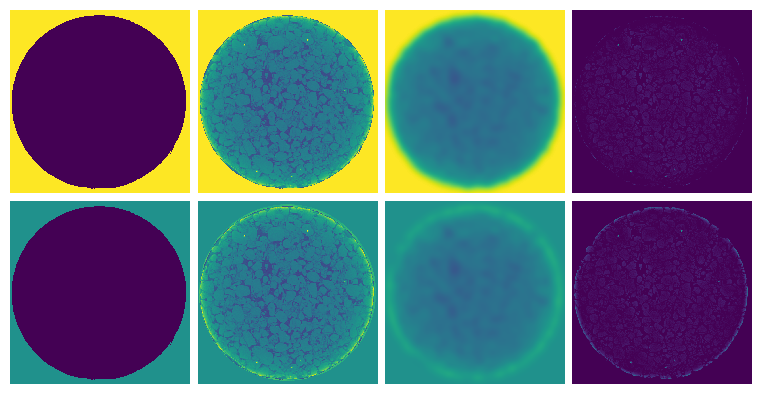

In [9]:
img_circ = np.full_like(img, circ_med) * img_border
img_bg_circ = img + img_circ
img_circ_smooth = filters.gaussian(img_bg_circ, sigma=img.shape[0]//50)
img_sub_circ = img - img_circ_smooth
fig, axes = view.images(
    [
        img_max, img_bg_max, img_max_smooth, img_sub_max,
        img_circ, img_bg_circ, img_circ_smooth, img_sub_circ,
    ], imgs_per_row=4, vmin=0, vmax=1)
plt.show()

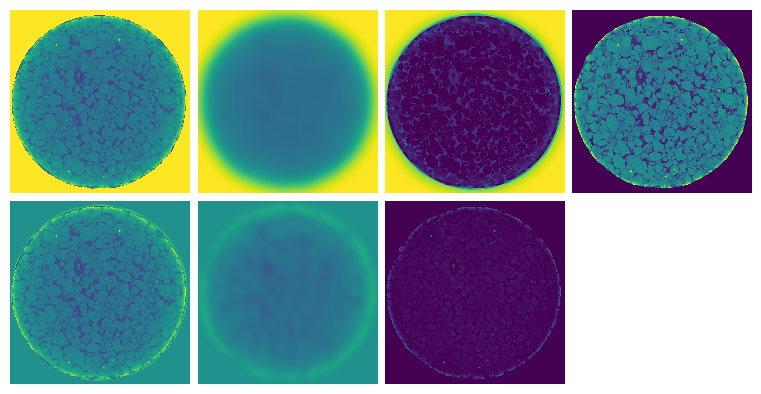

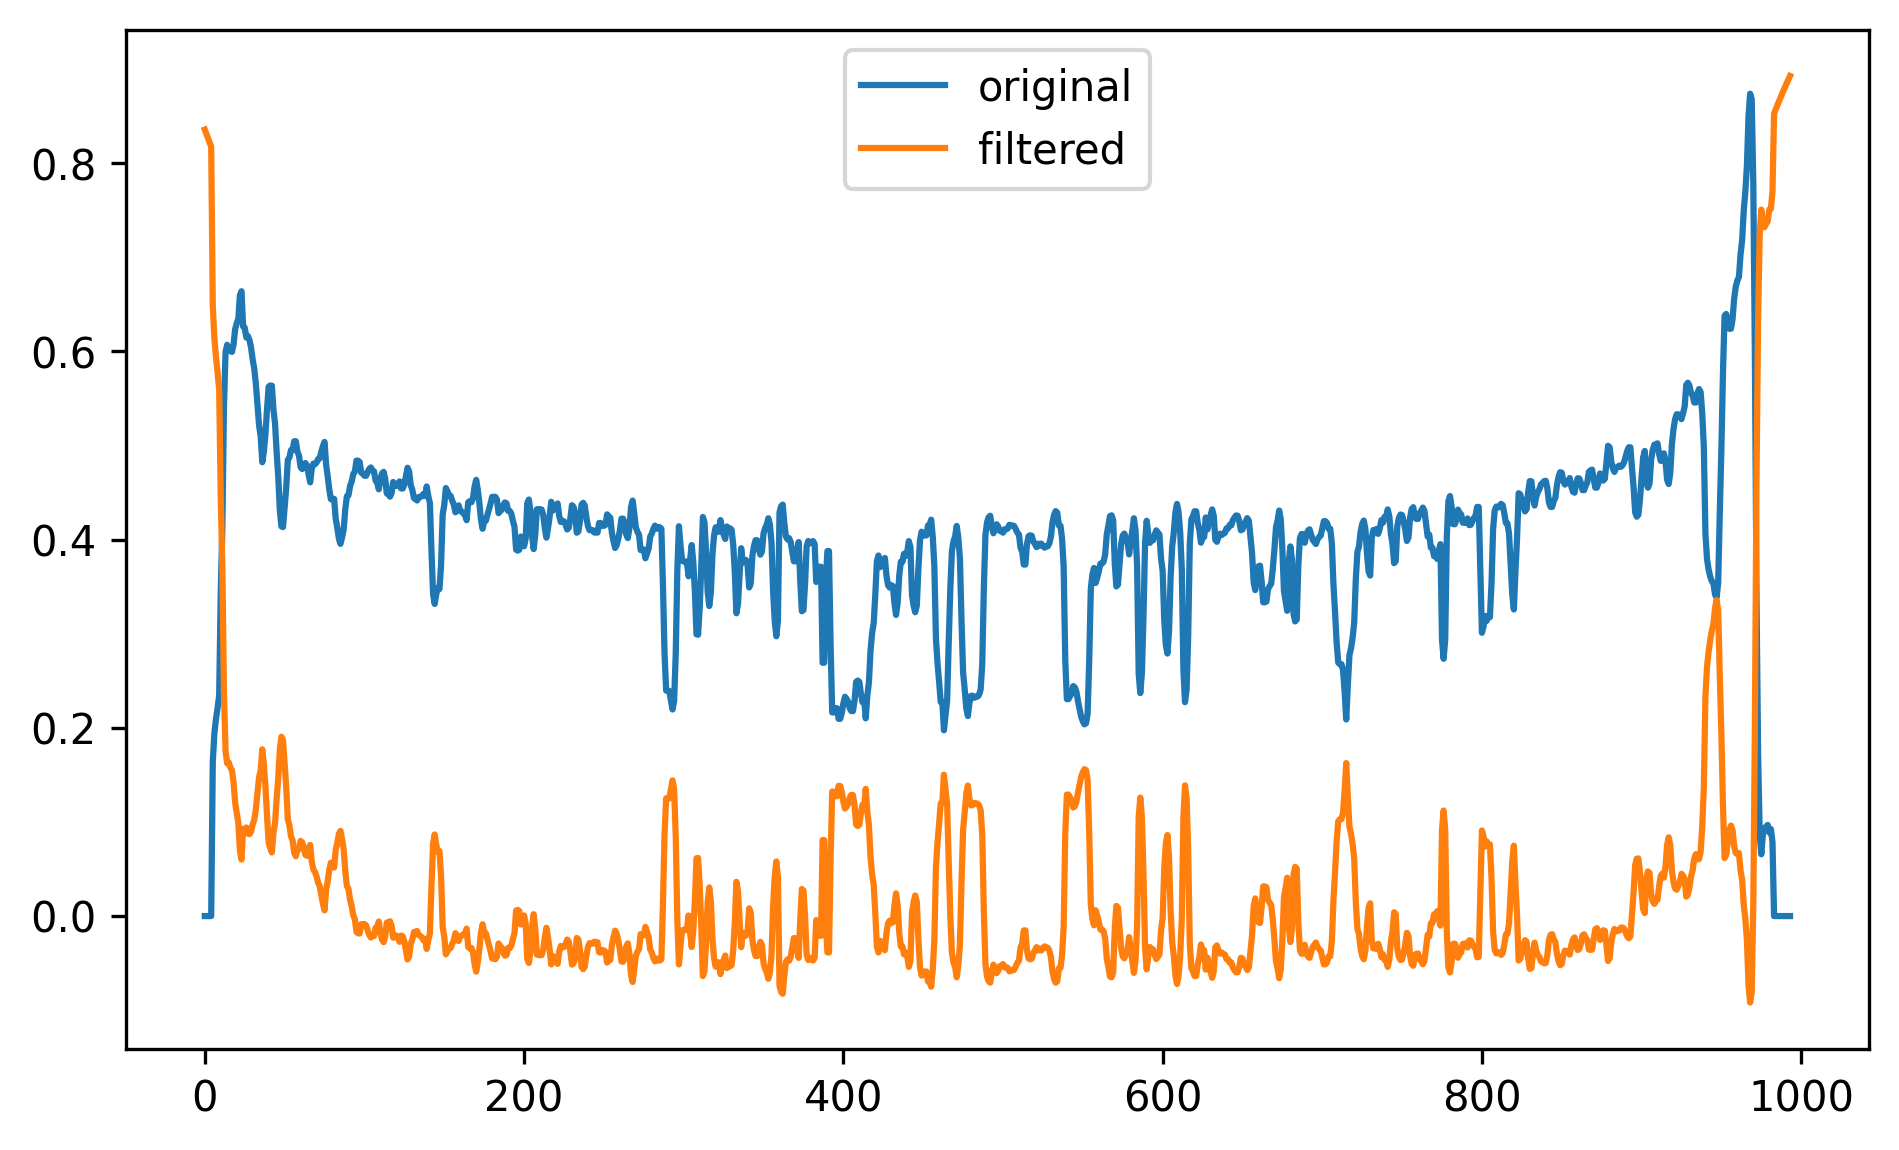

In [10]:
img_max = np.full_like(img, np.max(img)) * img_border
img_bg_max = img + img_max
img_max_smooth = filters.gaussian(img_bg_max, sigma=img.shape[0]//25)
# img_max_filter = (img_max_smooth > np.median(img)) * img_max_smooth - img
img_max_filter = img_max_smooth - img
img_sub_max = img - img_max_filter
img_circ = np.full_like(img, circ_med) * img_border
img_bg_circ = img + img_circ
img_circ_smooth = filters.gaussian(img_bg_circ, sigma=img.shape[0]//50)
img_sub_circ = img - img_circ_smooth
fig, axes = view.images(
    [
        img_bg_max, img_max_smooth, img_max_filter, img_sub_max,
        img_bg_circ, img_circ_smooth, img_sub_circ,
    ], imgs_per_row=4, vmin=0, vmax=1)
plt.show()
fig, ax = plt.subplots(figsize=(7.5, 4.5), dpi=300)
ax.plot(img[img.shape[0]//2, :], label='original')
ax.plot(img_max_filter[img.shape[0]//2, :], label='filtered')
ax.legend()
plt.show()

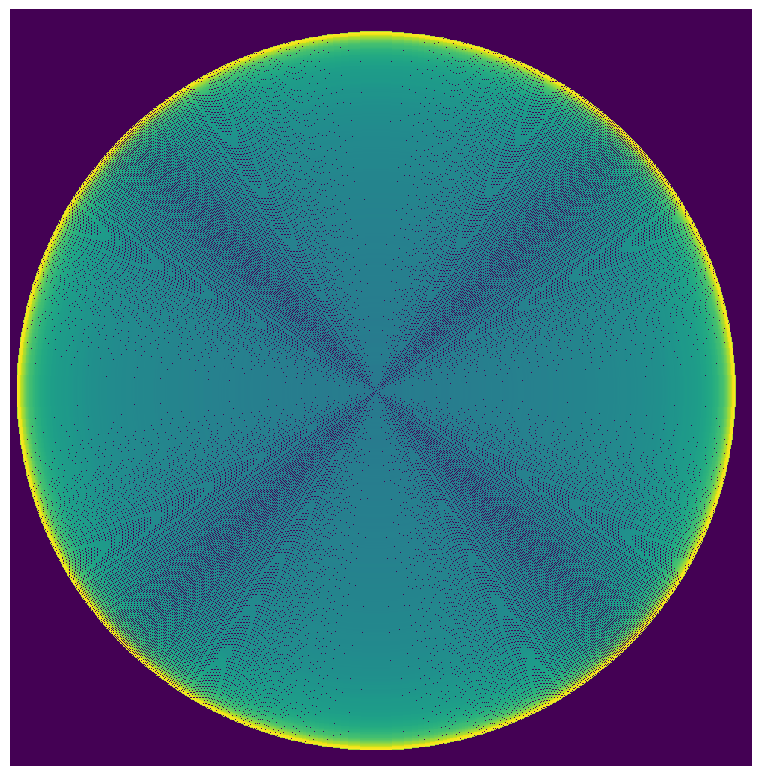

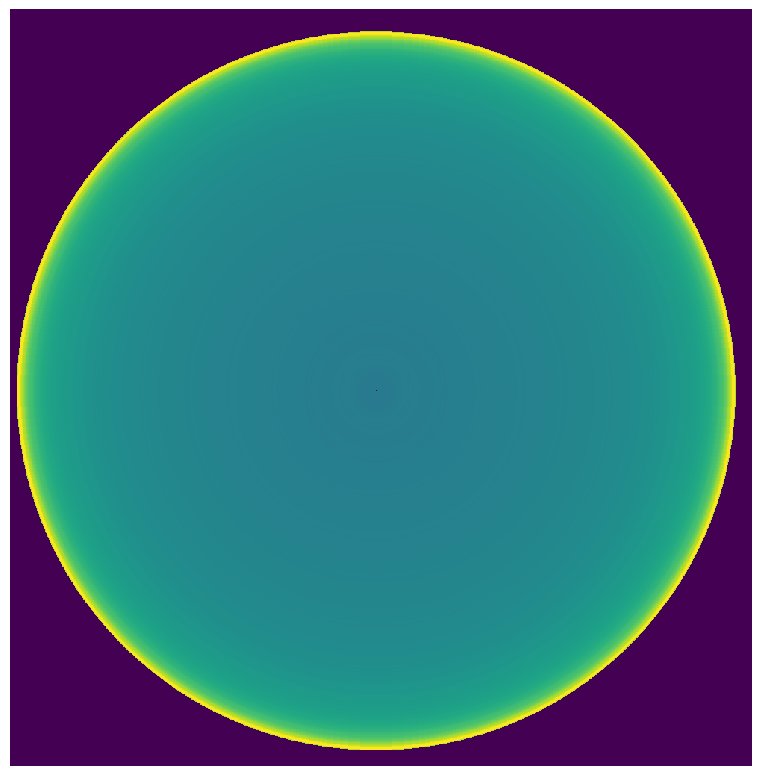

In [11]:
img_radial = np.zeros_like(img)
for r_sub in np.arange(0, r)[::-1]:
    # Draw circle
    circ_rows, circ_cols = draw.circle_perimeter(
        cy, cx, r - r_sub, shape=img.shape)
    # Get the average of the 50 largest values
    circ_avg_max = np.median(
        [
            img[circ_rows, circ_cols][i]
            for i in np.argsort(-img[circ_rows, circ_cols])[:50]
        ]
    )
    img_radial[circ_rows, circ_cols] = circ_avg_max
fig, ax = view.images(img_radial)
plt.show()
img_radial = filters.median(img_radial)
fig, ax = view.images(img_radial)
plt.show()

C:\Users\gusb\AppData\Local\Temp\ipykernel_13720\4111480345.py:10: RuntimeWarning: invalid value encountered in divide
  img_div_rad = img / img_rad_filter


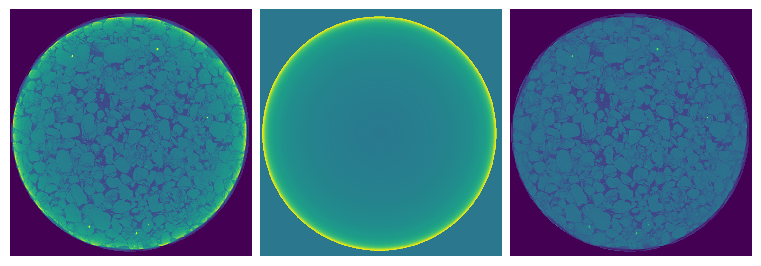

In [12]:
img_max = np.full_like(img, np.max(img)) * img_border
img_bg_max = img + img_max
img_max_smooth = filters.gaussian(img_bg_max, sigma=img.shape[0]//25)
img_max_filter = img_max_smooth - img
# Radial filter
img_rad = img_radial
img_rad[img_rad == 0] = np.median(img)
img_rad_filter = img_rad * img / np.mean(img)
img_sub_rad = img - img_rad_filter
img_div_rad = img / img_rad_filter
fig, axes = view.images(
    [
        img, img_radial, img / img_rad * np.median(img)
    ], vmin=0, vmax=1)
plt.show()

### Test on full dataset

Loading images...
--> Images loaded as 3D array:  (996, 1014, 994)
imgs.dtype=dtype('float64')
Plotting images: [250, 500, 750]


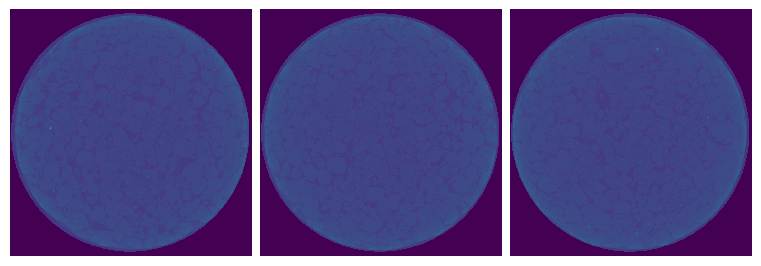

In [3]:
imgs_path = Path('../data/F83_01_raw')
slices = [250, 500, 750]
imgs = segment.load_images(
    imgs_path,
    slice_crop=None,
    convert_to_float=True,
    file_suffix='.tiff'
)
print(f'{imgs.dtype=}')
fig, axes = view.plot_slices(
    imgs,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

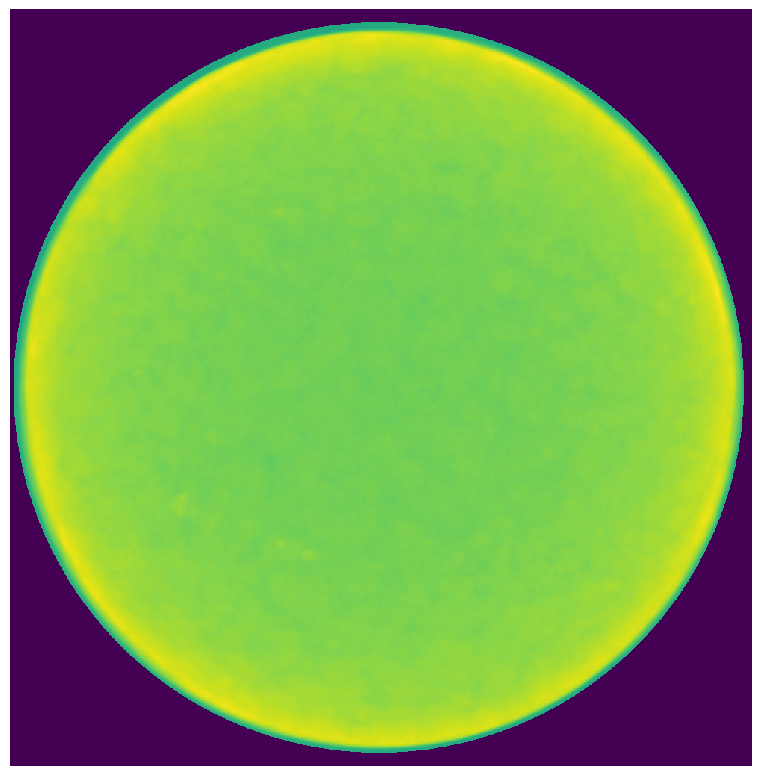

In [4]:
img_avg = np.mean(imgs, axis=0)
fig, ax = view.images(img_avg)
plt.show()

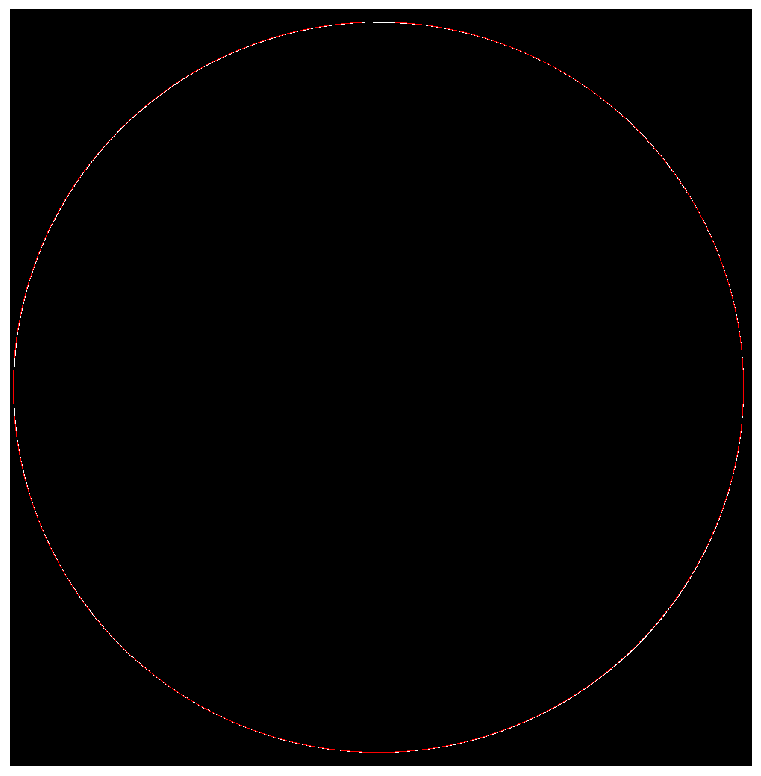

In [5]:
def fit_circle_to_edges(edge_img):
    # Perform a Hough Transform
    hough_radii = np.arange(edge_img.shape[0] // 4, edge_img.shape[0]//2, 2)
    hspaces = transform.hough_circle(edges, hough_radii)
    results = transform.hough_circle_peaks(hspaces, hough_radii, num_peaks=1)
    accum, center_x, center_y, radius = [row[0] for row in results]
    return center_x, center_y, radius
# Detect edges in image
edges = feature.canny(
    img_avg, sigma=2.0,
)
cx, cy, r = fit_circle_to_edges(edges)
# Draw circle
rows, cols = draw.circle_perimeter(cy, cx, r, shape=img_avg.shape)
edges_rgb = color.gray2rgb(util.img_as_ubyte(edges))
edges_rgb[rows, cols] = (255, 0, 0)
fig, ax = view.images(edges_rgb)
plt.show()

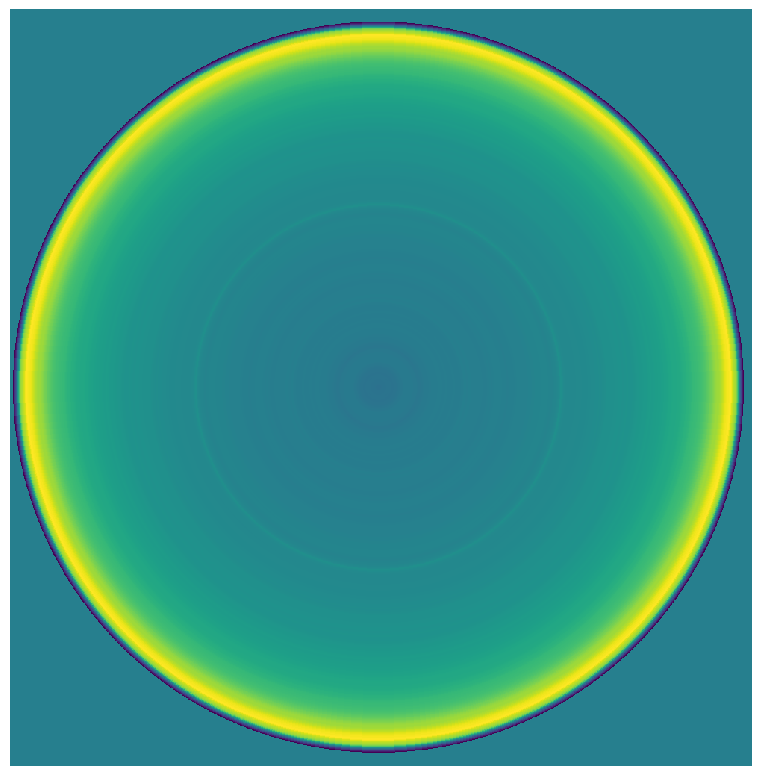

In [6]:
def create_radial_filter(img, center_x, center_y, radius):
    radial_filter = np.zeros_like(img)
    for r_sub in np.arange(0, radius)[::-1]:
        # Draw circle
        circ_rows, circ_cols = draw.circle_perimeter(
            center_y, center_x, radius - r_sub, shape=img.shape)
        # Get the average of the 50 largest values
        circ_avg_max = np.median(
            [
                img[circ_rows, circ_cols][i]
                for i in np.argsort(-img[circ_rows, circ_cols])[:50]
            ]
        )
        radial_filter[circ_rows, circ_cols] = circ_avg_max
    radial_filter = filters.median(radial_filter)
    radial_filter[radial_filter == 0] = np.median(img)
    return radial_filter
radial_filter = create_radial_filter(img_avg, cx, cy, r)
fig, ax = view.images(radial_filter)
plt.show()

Plotting images: [250, 500, 750]
Plotting images: [250, 500, 750]


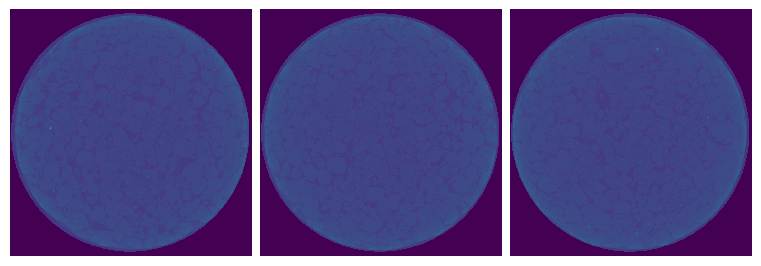

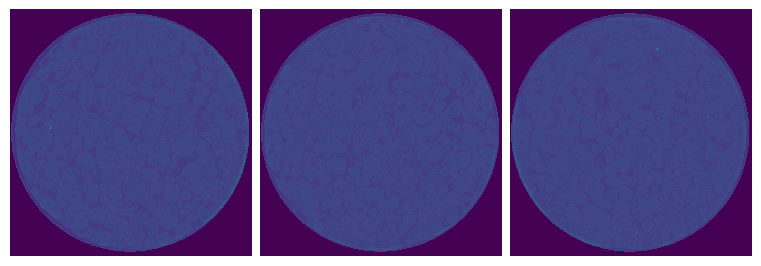

In [7]:
total_med = np.median(imgs)
imgs_rad_filt = [
    imgs[i, ...] / radial_filter * total_med
    for i in range(imgs.shape[0])
]
imgs_rad_filt = np.stack(imgs_rad_filt)
# This may need to be expanded if the median changes much per slice
# imgs_rad_filt = [
#     imgs * np.median(imgs[i, ...]) / radial_filter * total_med
#     for i in range(imgs.shape[0])
# ]
fig, axes = view.plot_slices(
    imgs,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)
fig, axes = view.plot_slices(
    imgs_rad_filt,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [25.5, 99.98]...
--> Preprocessing complete.


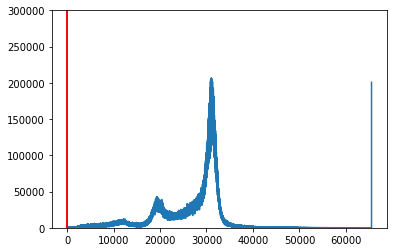

Plotting images: [250, 500, 750]


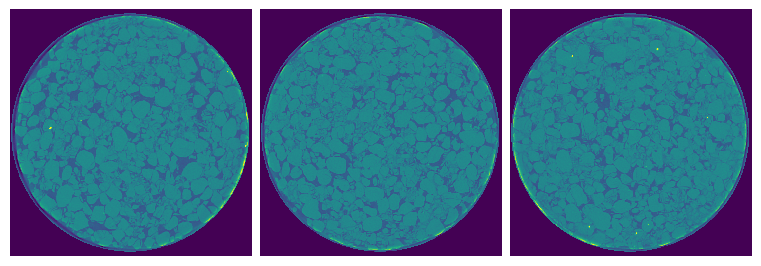

In [8]:
plo = 25.5
phi = 99.98
# Rescale images
imgs_pre = segment.preprocess(
    imgs_rad_filt, median_filter=True, rescale_intensity_range=[plo, phi])
# Plot histogram
hist, bins_centers = exposure.histogram(imgs_pre)
lo = np.percentile(imgs_rad_filt, plo)
hi = np.percentile(imgs_rad_filt, phi)
fig, ax = plt.subplots()
ax.plot(bins_centers, hist)
ax.axvline(lo, c='red')
ax.axvline(hi, c='red')
ax.set_ylim([0, 3e5])
plt.show()
# Plot rescaled images
fig, axes = view.plot_slices(
    imgs_pre,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)
plt.show()

Calculating thresholds from local minima...
--> 3 peak(s) found: [11648, 19584, 31104]
--> 2 minima found: [14976, 22912]


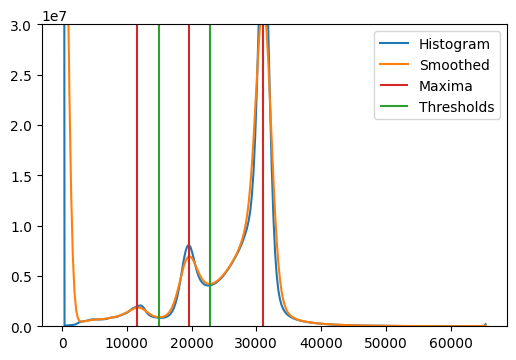

In [9]:
thresholds, fig, ax = segment.threshold_multi_min(
    imgs_pre, nbins=256, nthresholds='all', return_fig_ax=True,
    ylims=[0, 3e7], plt_kwargs={'dpi': 100})
plt.show()

## Failed semantic seg

Plotting images: [250, 500, 750]


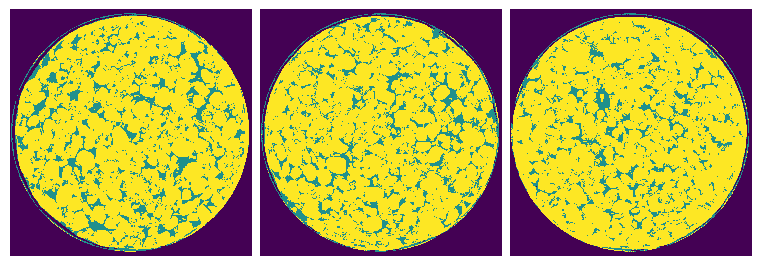

imgs_semantic = 0


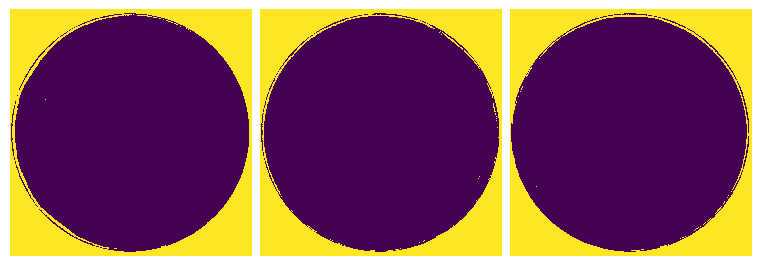

imgs_semantic = 1


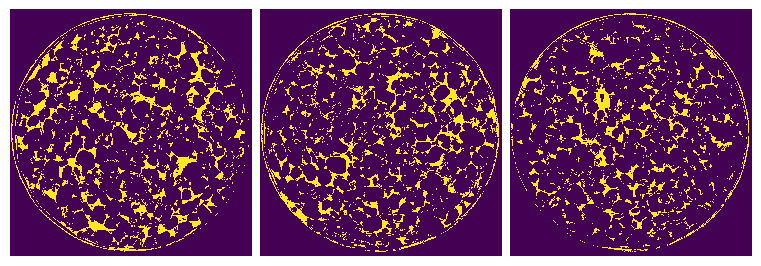

imgs_semantic = 2


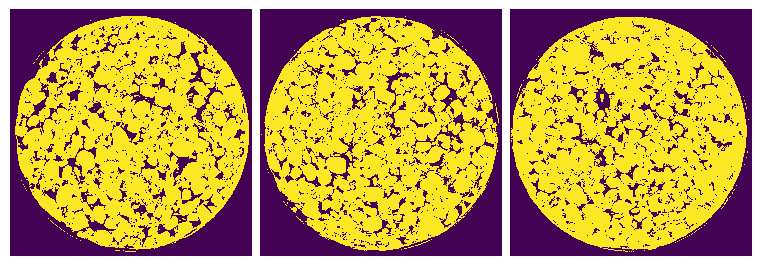

In [10]:
imgs_semantic = segment.isolate_classes(imgs_pre, thresholds)
fig, axes = view.plot_slices(imgs_semantic, slices=slices)
plt.show()
for i in range(len(thresholds) + 1):
    print('imgs_semantic =', i)
    fig, axes = view.plot_slices(
        imgs_semantic==i,
        slices=slices,
        print_slices=False,
        fig_w=7.5,
        dpi=100
    )
    plt.show()

Segmenting images...
--> Number of particle(s) before border exclusion:  30093
--> Excluding border particles...
--> Segmentation complete. 29095 particle(s) segmented.


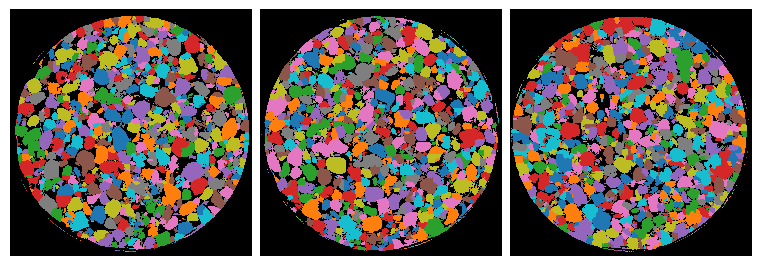

In [11]:
imgs = None
edges = None
edges_rgb = None
radial_filter = None
imgs_rad_filt = None
imgs_pre = None
imgs_labeled = segment.watershed_segment(
    imgs_semantic==len(thresholds),
    min_peak_distance=6,
    exclude_borders=True,
    return_dict=False
)
fig, axes = view.plot_color_labels(
    imgs_labeled,
    slices=slices,
    fig_w=7.5,
    dpi=100
)

In [12]:
imgs_labeled_unique = np.unique(imgs_labeled)
print(f'{imgs_labeled_unique.shape=}')
print(f'{imgs_labeled_unique[:10]=}')

imgs_labeled_unique.shape=(29096,)
imgs_labeled_unique[:10]=array([  0, 632, 639, 652, 653, 671, 680, 699, 727, 728], dtype=uint16)


In [14]:
labels_combined_dir_path = Path('../results/F83_01_combined_labels')
labels_combined = segment.merge_segmentations(imgs_semantic, imgs_labeled)
segment.save_images(labels_combined, labels_combined_dir_path)

996 image(s) saved to: C:\Users\gusb\Research\mhe-analysis\results\F83_01_combined_labels


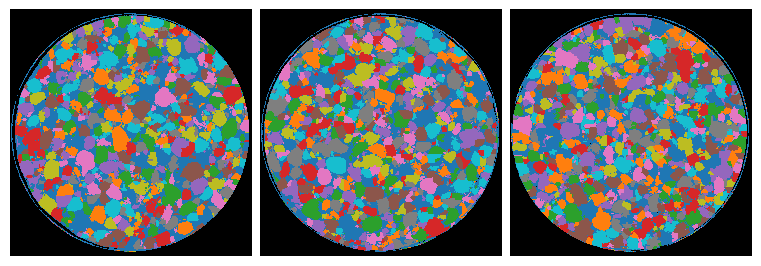

In [15]:
# labels_combined = segment.load_images(
#     labels_combined_dir_path, file_suffix='.tif')
fig, axes = view.plot_color_labels(
    labels_combined,
    slices=slices,
    fig_w=7.5,
    dpi=100
)
plt.show()